In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

In [4]:
df = pd.read_excel('/content/feature_extraction_3.xls',header=0,index_col='filename')
df=df.drop('Unnamed: 0',axis=1)

In [5]:
df.head()

,label,fsc_mean,fsc_var,fsb_mean,fsb_var,chroma_mean,chroma_var,rms_mean,rms_var,rolloff_mean,rolloff_var,zero_cross_rate_mean,zero_cross_rate_var,mel_spect_mean,mel_spect_var,tempo,contrast_mean,contrast_var,flatness_mean,flatness_var,chromacens_mean,chromacens_var,chromacqt_mean,chromacqt_var,mfcc_var1,mfcc_var2,mfcc_var3,mfcc_var4,mfcc_var5,mfcc_var6,mfcc_var7,mfcc_var8,mfcc_var9,mfcc_var10,mfcc_var11,mfcc_var12,mfcc_var13,mfcc_var14,mfcc_var15,mfcc_var16,...,mfcc_var21,mfcc_var22,mfcc_var23,mfcc_var24,mfcc_var25,mfcc_var26,mfcc_var27,mfcc_var28,mfcc_var29,mfcc_var30,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,mfcc_mean11,mfcc_mean12,mfcc_mean13,mfcc_mean14,mfcc_mean15,mfcc_mean16,mfcc_mean17,mfcc_mean18,mfcc_mean19,mfcc_mean20,mfcc_mean21,mfcc_mean22,mfcc_mean23,mfcc_mean24,mfcc_mean25,mfcc_mean26,mfcc_mean27,mfcc_mean28,mfcc_mean29,mfcc_mean30
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
blues.000000.wav,blues,1775.747689,168218.236006,1976.307347,113785.200935,0.412760,0.124600,0.130077,0.003457,3728.397217,1.083774e+06,0.082935,0.000704,5.936080,116.308929,123.046875,16.058756,19.803845,0.004524,0.000043,0.364948,0.007231,0.715723,0.081609,2363.8003,279.39330,339.52948,182.505050,161.23306,76.319214,50.420593,87.739970,79.62333,99.093220,67.070564,44.118890,32.695360,45.240295,46.027400,43.491344,...,24.663347,22.694063,32.512093,48.987160,144.584400,123.562450,93.804085,63.166240,43.962765,134.841830,-117.72195,125.181015,-23.219748,40.830822,-6.479303,20.148817,-16.122551,18.190498,-14.373737,10.967031,-9.302933,10.445532,-4.622816,8.263233,-7.594768,-2.402075,-3.283533,0.822000,-4.750408,-0.180276,-5.577494,-0.806646,-1.833445,-0.998209,2.528299,2.980887,-3.815330,-4.999353,-0.248520,1.828161
blues.000001.wav,blues,1782.417617,90849.067327,2003.793417,59525.192006,0.382884,0.126445,0.108474,0.001452,3820.067139,6.063278e+05,0.083744,0.001069,6.572237,95.425522,123.046875,16.368300,19.549463,0.004020,0.000020,0.282952,0.018823,0.559722,0.080958,2791.3303,176.23187,233.03687,154.677150,157.17673,81.443260,81.816870,48.370235,73.39588,54.098415,45.634712,38.507904,30.781233,45.999275,67.424470,56.699570,...,49.580303,33.116814,43.521040,35.473625,48.438095,39.263805,24.058897,34.221290,27.976450,50.443913,-135.93390,121.566590,-19.638802,53.807148,-8.637189,22.065144,-15.509302,19.643580,-11.531193,16.245016,-12.016334,8.276547,-7.604501,8.869481,-7.068740,4.082204,-6.163401,-0.030456,-3.721992,5.719011,-1.446377,0.119136,-4.970406,-2.800108,2.132017,1.239747,-7.189402,-6.137180,-1.379605,1.629855
blues.000002.wav,blues,1810.274575,90165.503975,2091.004353,77975.685006,0.312193,0.084679,0.137133,0.004237,4015.404053,7.952296e+05,0.073629,0.000339,5.914489,49.824261,123.046875,15.574113,13.488349,0.004063,0.000015,0.314685,0.008184,0.581093,0.053507,2878.1914,251.35106,180.89378,194.983400,131.36943,83.066574,86.431015,56.731907,85.32875,34.147152,51.533710,35.507885,58.172592,31.331842,51.846485,93.481260,...,28.265402,38.441400,40.401665,41.409573,43.351456,54.865417,74.956580,79.361660,110.541020,106.075070,-122.89359,116.996320,-16.112074,43.206470,-5.183577,23.197485,-13.409999,16.089487,-15.426331,11.875726,-8.611085,12.216978,-3.501803,7.045293,-4.834755,2.721860,-1.355400,2.157378,-1.596847,3.405140,-6.599291,-2.585352,-4.982160,-5.021442,0.301683,-1.802398,-6.943006,-3.287982,3.770696,3.792954
blues.000003.wav,blues,1652.650516,103062.026806,1968.470394,68974.341182,0.331422,0.090406,0.137032,0.002222,3531.060791,7.868272e+05,0.068802,0.000251,5.979826,73.155647,123.046875,16.008676,16.714017,0.003533,0.000009,0.235074,0.023742,0.508702,0.074759,2381.3918,299.47412,90.93322,127.117730,136.83224,112.011314,66.211006,63.257427,96.00789,50.300262,52.448627,62.037530,37.281975,35.898823,46.775154,39.020157,...,20.493862,26.093105,34.237995,40.886590,41.238617,27.881536,32.647710,40.982030,65.769070,111.598

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9989 entries, blues.000000.wav to rock.000999.wav
Data columns (total 84 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   label                 9989 non-null   object 
 1   fsc_mean              9989 non-null   float64
 2   fsc_var               9989 non-null   float64
 3   fsb_mean              9989 non-null   float64
 4   fsb_var               9989 non-null   float64
 5   chroma_mean           9989 non-null   float64
 6   chroma_var            9989 non-null   float64
 7   rms_mean              9989 non-null   float64
 8   rms_var               9989 non-null   float64
 9   rolloff_mean          9989 non-null   float64
 10  rolloff_var           9989 non-null   float64
 11  zero_cross_rate_mean  9989 non-null   float64
 12  zero_cross_rate_var   9989 non-null   float64
 13  mel_spect_mean        9989 non-null   float64
 14  mel_spect_var         9989 non-null   float64
 15  

In [7]:
print("Data has",df.shape)
df.label.value_counts().reset_index()

Data has (9989, 84)


,index,label
0,pop,1000
1,country,1000
2,classical,1000
3,disco,1000
4,reggae,1000
5,hiphop,1000
6,rock,1000
7,metal,1000
8,blues,999
9,jazz,990


In [8]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [9]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]


In [10]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index()
df_shuffle

,filename,label,fsc_mean,fsc_var,fsb_mean,fsb_var,chroma_mean,chroma_var,rms_mean,rms_var,rolloff_mean,rolloff_var,zero_cross_rate_mean,zero_cross_rate_var,mel_spect_mean,mel_spect_var,tempo,contrast_mean,contrast_var,flatness_mean,flatness_var,chromacens_mean,chromacens_var,chromacqt_mean,chromacqt_var,mfcc_var1,mfcc_var2,mfcc_var3,mfcc_var4,mfcc_var5,mfcc_var6,mfcc_var7,mfcc_var8,mfcc_var9,mfcc_var10,mfcc_var11,mfcc_var12,mfcc_var13,mfcc_var14,mfcc_var15,...,mfcc_var21,mfcc_var22,mfcc_var23,mfcc_var24,mfcc_var25,mfcc_var26,mfcc_var27,mfcc_var28,mfcc_var29,mfcc_var30,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,mfcc_mean11,mfcc_mean12,mfcc_mean13,mfcc_mean14,mfcc_mean15,mfcc_mean16,mfcc_mean17,mfcc_mean18,mfcc_mean19,mfcc_mean20,mfcc_mean21,mfcc_mean22,mfcc_mean23,mfcc_mean24,mfcc_mean25,mfcc_mean26,mfcc_mean27,mfcc_mean28,mfcc_mean29,mfcc_mean30
0,pop.000888.wav,7,3590.582843,6.778287e+05,3175.023604,114050.695989,0.294341,0.053589,0.252308,0.013893,7518.394775,2.716830e+06,0.184734,0.005223,45.585415,8728.553711,99.384014,14.848152,19.055000,0.095372,8.270343e-03,0.233900,0.001333,0.464446,0.021010,3962.5460,709.67065,326.00757,250.81021,165.071370,247.239760,108.587130,76.704310,100.584930,69.980675,66.928560,40.738148,85.101036,56.424484,78.366280,...,62.684753,63.493526,63.589460,51.263890,46.879784,40.231110,25.160889,44.635723,67.936900,37.234340,-10.727305,50.537930,8.609426,20.143036,3.655872,-7.647868,10.791856,4.679776,10.910558,0.493899,-3.177578,2.695300,-5.651231,-5.386821,-2.107299,-0.940546,2.597380,1.896435,4.849185,1.582755,0.352884,1.952791,0.782305,-0.392257,2.574002,1.804677,-0.695059,-3.114157,-3.105547,-0.751744
1,hiphop.000707.wav,4,2249.686489,1.476293e+06,2880.845352,379237.260917,0.305058,0.068914,0.269476,0.005656,5164.123535,8.596283e+06,0.069646,0.005072,9.384214,108.528358,184.570312,28.763514,26.975175,0.028252,2.885416e-03,0.114840,0.001602,0.255372,0.009965,6296.6440,1189.74820,747.73450,179.17035,251.687260,143.161450,50.414660,47.633083,61.191845,40.530540,28.201650,25.809195,41.959347,25.271334,33.296700,...,26.333210,25.267609,27.507906,34.121666,39.892240,74.034110,79.990840,59.084946,67.798134,108.669100,-94.259420,94.062584,54.501785,21.165195,16.222830,19.711422,8.268105,7.552387,-0.382893,-1.244691,0.877767,0.650480,0.676871,1.192138,-0.921278,-2.717280,0.213239,0.428072,-2.612690,-1.451878,-6.499574,-5.830388,-5.543335,-6.677766,-4.609753,-3.701304,-4.204239,0.473313,2.527312,3.382849
2,metal.000742.wav,6,2699.764045,2.636366e+05,2338.846546,47399.172563,0.556526,0.032226,0.036773,0.000038,5396.759033,5.690815e+05,0.137699,0.002482,0.290277,0.363140,129.199219,19.438497,22.515672,0.013535,9.483035e-05,0.302401,0.002194,0.575639,0.035042,1215.1543,339.36298,100.81013,112.90309,43.194490,73.954994,74.733830,55.683650,44.948925,18.995674,20.501373,18.355974,16.896900,22.661224,19.892687,...,10.463013,19.607239,20.567270,15.234581,11.923704,23.703110,11.843621,10.305891,11.791101,9.719731,-205.501280,80.568190,-21.736967,75.732056,-17.500837,38.305386,-14.316934,25.729970,-11.481972,17.305790,-6.430709,14.278493,-12.428418,11.190591,-3.544644,6.073983,-8.794104,0.556218,-5.916461,-2.866019,-6.214200,-2.621964,-0.307286,-0.234024,-5.756365,-6.900153,-5.069646,-2.735559,-1.876393,-6.234316
3,jazz.000083.wav,5,1319.965885,1.353827e+05,1628.310995,92245.025032,0.504995,0.156726,0.099307,0.000872,2743.253174,8.178690e+05,0.042501,0.000308,0.271738,0.828372,151.999081,26.847323,19.882617,0.000684,6.197879e-07,0.315087,0.013098,0.532549,0.073010,2333.3755,541.57940,648.90460,131.61028,167.015800,87.011020,64.497590,118.946370,61.595886,64.436134,41.028370,37.950640,42.649548,39.962350,25.711094,...,29.994620,26.597609,23.293894,33.808353,27.656553,31.057482,31.718122,35.902140,28.569183,76.061120,-193.926530,134.433780,-35.527485,47.614610,14.194020,22.977060,-8.628963,8.533306,-15.404654,11.355152,-8.341826,-0.211575,-3.972666,

In [11]:
# remove irrelevant columns
df_shuffle.drop('filename', axis=1,inplace=True) 
df_y = df_shuffle.pop('label')
df_X = df_shuffle

In [12]:
# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [13]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6992 records out of 9989 which is 70%
Dev set has 1978 records out of 9989 which is 20%
Test set has 1019 records out of 9989 which is 10%


In [14]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [15]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

TF version:- 2.4.1


**HELPER FUNCTIONS**


In [17]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
#fitting the data 
def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])
# a plot to visuzlize our accuracies
def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

**Model Evaluation**

In [18]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               21504     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 63,306
Trainable params: 63,306
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
55/55 [==============================] - 4s 12ms/step - loss: 1.7800 - accuracy: 0.3954 - val_loss: 1.0318 - val_accuracy: 0.6426
Epoch 2/70
55/55 [==============================] - 0s 3ms/step - loss: 0.9052 - accuracy: 0.7028 - val_

Max. Validation Accuracy 0.878159761428833


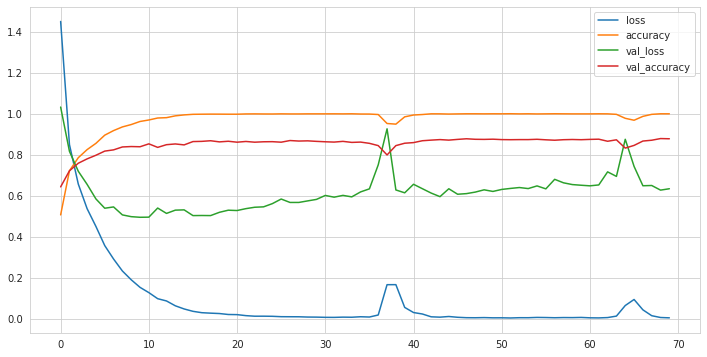

In [19]:
plotHistory(model_1_history)

In [22]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=20, optimizer='adam')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               43008     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

Max. Validation Accuracy 0.8791708946228027


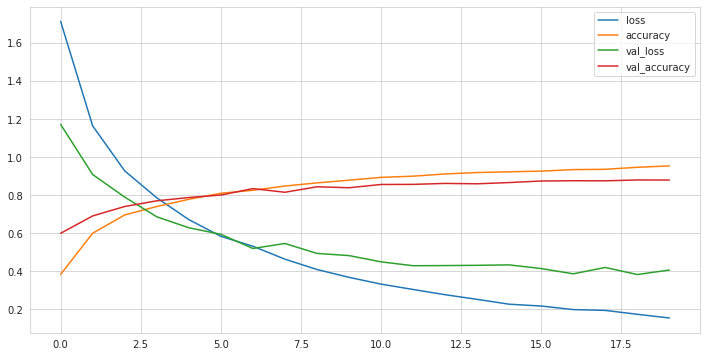

In [23]:
plotHistory(model_2_history)

In [29]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=150, optimizer='sgd')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               43008     
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)               

Max. Validation Accuracy 0.8665318489074707


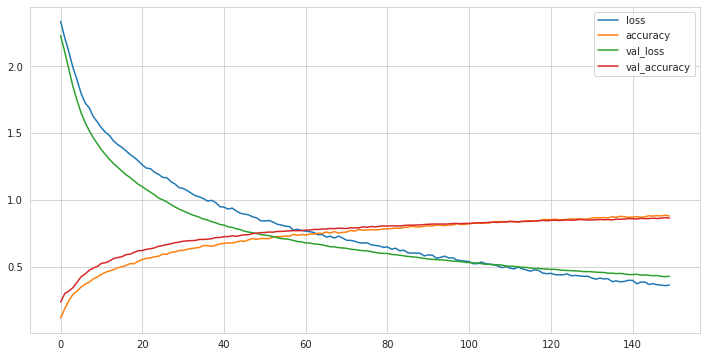

In [30]:
plotHistory(model_3_history)

**Selecting the best model**

In [33]:
test_loss, test_acc  = model_2.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

8/8 [==============================] - 0s 2ms/step - loss: 0.3754 - accuracy: 0.8950
The test Loss is : 0.3754037022590637

The Best test Accuracy is : 89.49950933456421


In [34]:
model_2.evaluate(X_train, y_train, batch_size=128)

55/55 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.9914


[0.03492581099271774, 0.9914187788963318]

In [35]:
!apt-get -qq install -y graphviz && pip install pydot

In [36]:
!apt-get -qq install -y graphviz && pip install keras-visualizer

In [37]:
from keras_visualizer import visualizer

In [39]:
visualizer(model_3,format='pdf',view=True)# our model but in with real neurons